In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, experimental, BatchNormalization
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import cv2
import gc 
import os
!pip install rarfile
import rarfile

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Matplotlib config
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
plt.rc('font', **font)
plt.rcParams["figure.figsize"] = (12,8)

In [3]:
# Global variables
colormode = 'grayscale' # 'rgb'
size_im = (125,125) # (300,300)
epochs = 10
kfold = 10

if colormode == 'rgb':
    input_im = size_im + (3,)
else:
    input_im = size_im + (1,)

source_df = 'dataset_images_minitest.csv'
source_data = 'data_folder.rar'
extract_data = 'data_folder'

In [4]:
if not source_df in os.listdir():
    ! wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-R2tYoDl_P56LevfF95tP_qv1MbcVZQJ' -O dataset_images_minitest.csv

# Trick to download big files!
if not source_data in os.listdir():
    ! curl -c cookies "https://drive.google.com/uc?export=download&id=13zpbNNGYafdYWmdQO0-ArGjm9ipZkD5Q" > intermezzo.html
    ! curl -L -b cookies "https://drive.google.com$(cat intermezzo.html | grep -Po 'uc-download-link" [^>]* href="\K[^"]*' | sed 's/\&amp;/\&/g')" > data_folder.rar
    ! rm intermezzo.html; rm cookies

if extract_data in os.listdir():
    ! ls -ls
else:
    ! unrar x data_folder.rar > quiet.txt; rm quiet.txt; ls -lt

total 927508
   768 -rw-r--r-- 1 david david    783170 Sep  4 16:29 Diabetes-sev-vali.ipynb
   324 -rw-r--r-- 1 david david    329264 Sep 21 01:55 Diabetes.ipynb
    80 -rw-r--r-- 1 david david     79718 Oct 13 18:35 categorical_img.ipynb
     4 drwxr-xr-x 3 david david      4096 Sep 21 10:53 data
  1060 drwxr-xr-x 2 david david   1081344 Jul 30  2018 data_folder
914700 -rw-r--r-- 1 david david 936646595 Sep 23 23:59 data_folder.rar
   724 -rw-r--r-- 1 david david    739037 Sep 23 23:56 dataset_images_minitest.csv
     4 drwxr-xr-x 2 david david      4096 Sep  3 17:30 docs
    76 -rw-r--r-- 1 david david     75402 Sep 24 13:44 image_pre.ipynb
    20 -rw-r--r-- 1 david david     19698 Oct 13 18:00 img-cla-deep_KF-loss-acc.pdf
   148 -rw-r--r-- 1 david david    148558 Oct 13 18:00 img-cla-deep_KF-roc.pdf
  3884 -rw-r--r-- 1 david david   3975204 Oct 13 17:34 img-cla_0.h5
  3884 -rw-r--r-- 1 david david   3975204 Oct 13 17:42 img-cla_1.h5
    20 -rw-r--r-- 1 david david     19736 Oct 13 1

In [5]:
pre_labels = pd.read_csv(source_df,sep='\t')

# labels randomly sorted!
labels_df = pre_labels.sample(frac=1).reset_index(drop=True)

In [6]:
def rgb2gray(rgb):
    finim = np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    aim2 = finim.shape + (1,)
    finim = finim.reshape(aim2)
    return finim

if colormode == 'rgb':
    datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.2)
else:
    datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.2,preprocessing_function=rgb2gray)

train_it = datagen.flow_from_dataframe(labels_df,directory = extract_data,x_col = "filename", y_col = "category", \
                                       class_mode = "categorical",batch_size=32,target_size=size_im,subset='training')
valid_it = datagen.flow_from_dataframe(labels_df,directory = extract_data,x_col = "filename", y_col = "category", \
                                       class_mode = "categorical",batch_size=32,target_size=size_im,subset='validation')

Found 16790 validated image filenames belonging to 3 classes.
Found 4197 validated image filenames belonging to 3 classes.


(125, 125, 3)
0.013811764 0.9999


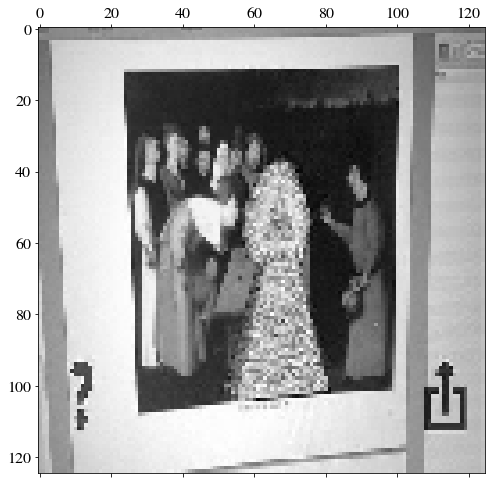

In [7]:
# Display a random image and first batch
# valid_it.class_indices dictonary with classes and labels
nran = np.random.randint(32)
imm = valid_it[0][0][nran]
print(imm.shape)
plt.matshow(np.array(imm,dtype='float'))
print(np.min(imm),np.max(imm))

In [8]:
# Conv2D model!
def Conv2D_model(input_shape,num_clases,deeper=False):
    model = Sequential()
    model.add(Conv2D(10,(3,3),activation='relu',input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(10,(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    if deeper == True:
        model.add(Conv2D(5,(5,5),activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(25,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_clases,activation='softmax'))
    return model

first_model = Conv2D_model(input_im,3)

# Compile the model.
first_model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [9]:
# Summary
# plot_model(model, show_shapes=True)
first_model.summary()

# Train the model.
first_train = first_model.fit(
  train_it,
  epochs=epochs,
  batch_size=32,
  validation_data = valid_it
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 123, 123, 10)      280       
_________________________________________________________________
batch_normalization (BatchNo (None, 123, 123, 10)      40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 59, 59, 10)        910       
_________________________________________________________________
batch_normalization_1 (Batch (None, 59, 59, 10)        40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8410)              0

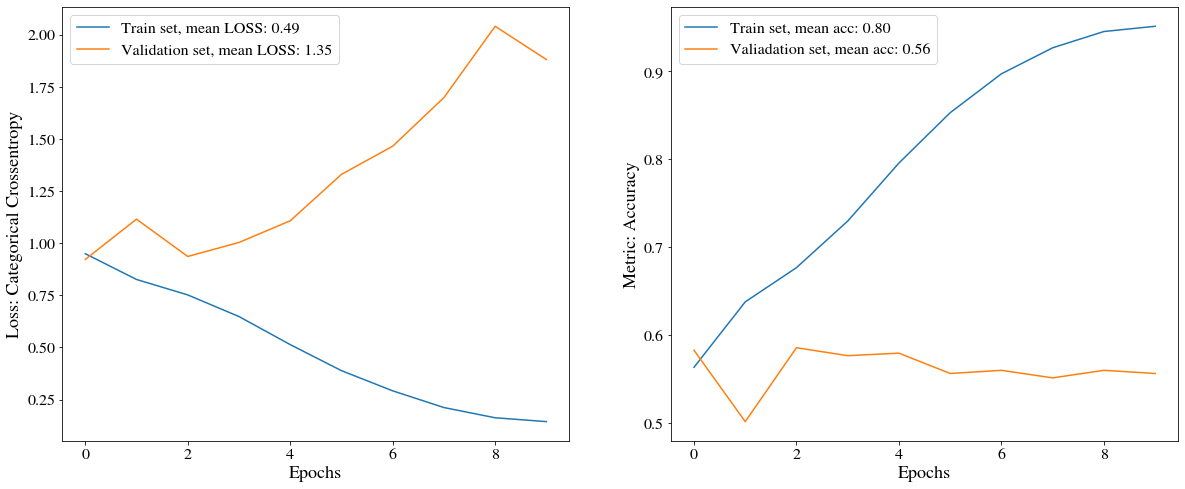

In [10]:
plt.rcParams["figure.figsize"] = (20,8)
fig, axs = plt.subplots(1,2)

axs[0].plot(first_train.history['loss'],'-',label=r'Train set, mean LOSS: %.2f'%np.mean(first_train.history['loss']))
axs[0].plot(first_train.history['val_loss'],'-',label=r'Validation set, mean LOSS: %.2f'%np.mean(first_train.history['val_loss']))

axs[0].set_xlabel(r'Epochs', fontsize=18)
axs[0].set_ylabel(r'Loss: Categorical Crossentropy', fontsize=18)
axs[0].legend(loc=0)

axs[1].plot(first_train.history['accuracy'],'-',label=r'Train set, mean acc: %.2f'%np.mean(first_train.history['accuracy']))
axs[1].plot(first_train.history['val_accuracy'],'-',label=r'Valiadation set, mean acc: %.2f'%np.mean(first_train.history['val_accuracy']))

axs[1].set_xlabel(r'Epochs', fontsize=18)
axs[1].set_ylabel(r'Metric: Accuracy', fontsize=18)
axs[1].legend(loc=0)

plt.savefig('img-cla_loss-acc.pdf')

In [11]:
predict_labels = first_model.predict(valid_it,batch_size=32)
true_labels = to_categorical(valid_it.labels)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
threeshold = dict()
roc_auc = dict()
for key, val in valid_it.class_indices.items():
    fpr[key], tpr[key], threeshold[key] = roc_curve(true_labels[:, val], predict_labels[:, val])
    roc_auc[key] = auc(fpr[key], tpr[key])

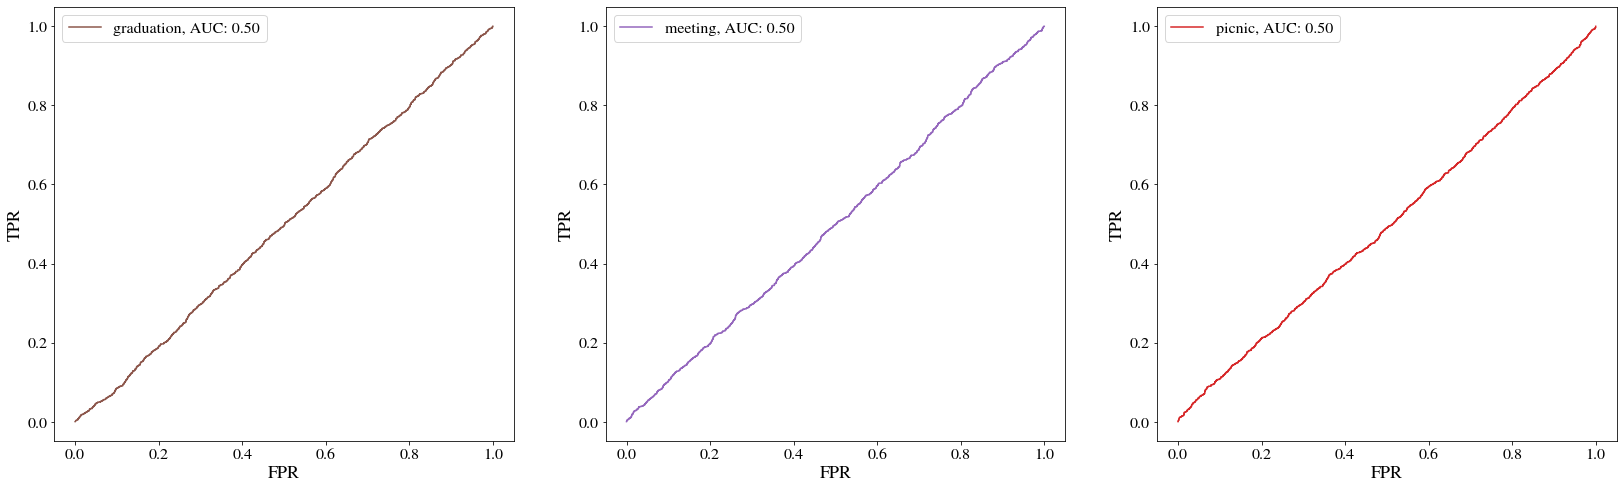

In [12]:
plt.rcParams["figure.figsize"] = (28,8)
fig, axs = plt.subplots(1,3)

color_dict = {'picnic':'C3','meeting':'C4','graduation':'C5'}

for key, val in valid_it.class_indices.items():
    axs[val].plot(fpr[key], tpr[key],color=color_dict[key],label=key+', AUC: %.2f'%roc_auc[key])
    axs[val].set_xlabel(r'FPR', fontsize=18)
    axs[val].set_ylabel(r'TPR', fontsize=18)
    axs[val].legend(loc=0)
    
plt.savefig('img-cla_roc.pdf')

In [13]:
# K-Fold Cross Validation
kf = KFold(n_splits = kfold)

i = 0

kc_dict = {}

for train_index, val_index in kf.split(labels_df['filename']):
    train_df = labels_df.iloc[train_index]
    val_df = labels_df.iloc[val_index]

    # create a data generator
    datagen = ImageDataGenerator(rescale=1./255.,preprocessing_function=rgb2gray)

    train_it = datagen.flow_from_dataframe(train_df,directory ='data_folder',x_col = "filename", y_col = "category", \
                                        class_mode = "categorical",batch_size=32,target_size=size_im)
    valid_it = datagen.flow_from_dataframe(val_df,directory ='data_folder',x_col = "filename", y_col = "category", \
                                        class_mode = "categorical",batch_size=32,target_size=size_im)
    
    model_kf = Conv2D_model(input_im,3)

    # Compile the model.
    model_kf.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )
    
    # Train the model.
    train_kf = model_kf.fit(
    train_it,
    epochs=epochs,
    batch_size=32,
    validation_data = valid_it
    )

    # save model and architecture to single file
    model_kf.save("img-cla_%i.h5"%i)

    predict_labels = model_kf.predict(valid_it,batch_size=32)
    true_labels = to_categorical(valid_it.labels)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    threeshold = dict()
    roc_auc = dict()
    for key, val in valid_it.class_indices.items():
        fpr[key], tpr[key], threeshold[key] = roc_curve(true_labels[:, val], predict_labels[:, val])
        roc_auc[key] = auc(fpr[key], tpr[key])

        kc_dict['loss_%i'%i] = train_kf.history['loss']
        kc_dict['val_loss_%i'%i] = train_kf.history['val_loss']
        kc_dict['accuracy_%i'%i] = train_kf.history['accuracy']
        kc_dict['val_accuracy_%i'%i] = train_kf.history['val_accuracy']
        kc_dict['fpr_%i'%i] = fpr
        kc_dict['tpr_%i'%i] = tpr
        kc_dict['roc_auc_%i'%i] = roc_auc
        kc_dict['class_dict_%i'%i] = valid_it.class_indices

    i += 1

Found 18888 validated image filenames belonging to 3 classes.
Found 2099 validated image filenames belonging to 3 classes.
Epoch 1/10
591/591 [==============================] - 171s 289ms/step - loss: 1.0026 - accuracy: 0.5357 - val_loss: 0.9301 - val_accuracy: 0.5650
Epoch 2/10
591/591 [==============================] - 168s 285ms/step - loss: 0.7889 - accuracy: 0.6552 - val_loss: 0.9710 - val_accuracy: 0.5641
Epoch 3/10
591/591 [==============================] - 166s 281ms/step - loss: 0.6967 - accuracy: 0.7110 - val_loss: 1.0452 - val_accuracy: 0.5612
Epoch 4/10
591/591 [==============================] - 166s 280ms/step - loss: 0.5579 - accuracy: 0.7779 - val_loss: 0.9479 - val_accuracy: 0.6012
Epoch 5/10
591/591 [==============================] - 167s 283ms/step - loss: 0.4282 - accuracy: 0.8423 - val_loss: 1.1431 - val_accuracy: 0.5750
Epoch 6/10
591/591 [==============================] - 167s 283ms/step - loss: 0.3011 - accuracy: 0.8960 - val_loss: 1.4181 - val_accuracy: 0.5727
E

591/591 [==============================] - 168s 284ms/step - loss: 0.7792 - accuracy: 0.6607 - val_loss: 1.1917 - val_accuracy: 0.5283
Epoch 3/10
591/591 [==============================] - 173s 292ms/step - loss: 0.6791 - accuracy: 0.7153 - val_loss: 0.9102 - val_accuracy: 0.6093
Epoch 4/10
591/591 [==============================] - 176s 297ms/step - loss: 0.5308 - accuracy: 0.7879 - val_loss: 0.9563 - val_accuracy: 0.5784
Epoch 5/10
591/591 [==============================] - 170s 288ms/step - loss: 0.4252 - accuracy: 0.8441 - val_loss: 1.0999 - val_accuracy: 0.5727
Epoch 6/10
591/591 [==============================] - 166s 280ms/step - loss: 0.2731 - accuracy: 0.9071 - val_loss: 1.2711 - val_accuracy: 0.5560
Epoch 7/10
591/591 [==============================] - 169s 285ms/step - loss: 0.1977 - accuracy: 0.9364 - val_loss: 1.5648 - val_accuracy: 0.5917
Epoch 8/10
591/591 [==============================] - 167s 282ms/step - loss: 0.2831 - accuracy: 0.8984 - val_loss: 1.5467 - val_accura

In [136]:
def stats_epochs(in_dict, metric, epochs):
    tab = [in_dict[metric+'_%i'%i] for i in range(epochs)]
    stacktab = np.vstack(tuple(tab))
    mean = np.mean(stacktab,axis=0)
    std = np.std(stacktab,axis=0)
    return mean, std

def stats_global(in_dict, metric, epochs):
    tab = [in_dict[metric+'_%i'%i] for i in range(epochs)]
    stacktab = np.vstack(tuple(tab))
    mean = np.mean(stacktab)
    std = np.std(stacktab)
    return mean, std

def best_performance(in_dict,epochs):
    # best formance according a mean roc_aucc over all classes
    auc_mean_tab = []
    for i in range(epochs):
        vals = kc_dict['roc_auc_%i'%i].values()
        aucm = np.mean(list(vals))
        auc_mean_tab.append(aucm)
    # number of the best iteration
    ilabel = np.argmax(auc_mean_tab)
    return ilabel, auc_mean_tab[i]

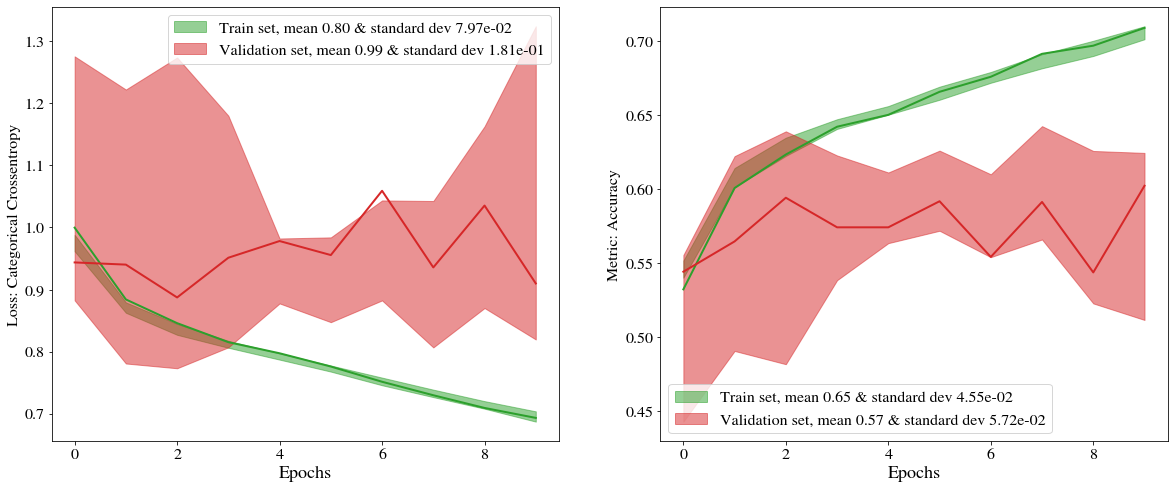

In [158]:
plt.rcParams["figure.figsize"] = (20,8)
fig, axs = plt.subplots(1,2)

# Global and by epoch statitics
loss_epoch_mean, loss_epoch_std = stats_epochs(kc_dict,'loss',epochs)
val_loss_epoch_mean, val_loss_epoch_std = stats_epochs(kc_dict,'val_loss',epochs)
acc_epoch_mean, acc_epoch_std = stats_epochs(kc_dict,'accuracy',epochs)
val_acc_epoch_mean, val_acc_epoch_std = stats_epochs(kc_dict,'val_accuracy',epochs)

loss_mean, loss_std = stats_global(kc_dict,'loss',epochs)
val_loss_mean, val_loss_std = stats_global(kc_dict,'val_loss',epochs)
acc_mean, acc_std = stats_global(kc_dict,'accuracy',epochs)
val_acc_mean, val_acc_std = stats_global(kc_dict,'val_accuracy',epochs)


axs[0].fill_between(np.arange(epochs),loss_epoch_mean - loss_epoch_std, \
                    loss_epoch_mean + loss_epoch_std,color='C2',alpha=0.5, \
                    label='Train set, mean %.2f & standard dev %.2e'%(loss_mean,loss_std))
axs[0].fill_between(np.arange(epochs),val_loss_epoch_mean - val_loss_epoch_std, \
                    val_loss_epoch_mean + val_loss_epoch_std,color='C3',alpha=0.5, \
                    label='Validation set, mean %.2f & standard dev %.2e'%(val_loss_mean,val_loss_std))

axs[1].fill_between(np.arange(epochs),acc_epoch_mean - acc_epoch_std, \
                    acc_epoch_mean + acc_epoch_std,color='C2',alpha=0.5, \
                    label='Train set, mean %.2f & standard dev %.2e'%(acc_mean,acc_std))
axs[1].fill_between(np.arange(epochs),val_acc_epoch_mean - val_acc_epoch_std, \
                    val_acc_epoch_mean + val_acc_epoch_std,color='C3',alpha=0.5, \
                    label='Validation set, mean %.2f & standard dev %.2e'%(val_acc_mean,val_acc_std))

#Iteration with best performance
iperf, auc_iperf = best_performance(kc_dict,epochs)
axs[0].plot(kc_dict['loss_%i'%iperf],lw=2.,color='C2')
axs[0].plot(kc_dict['val_loss_%i'%iperf],lw=2,color='C3')
axs[1].plot(kc_dict['accuracy_%i'%iperf],lw=2,color='C2')
axs[1].plot(kc_dict['val_accuracy_%i'%iperf],lw=2,color='C3')

axs[0].set_xlabel(r'Epochs', fontsize=18)
axs[0].set_ylabel(r'Loss: Categorical Crossentropy', fontsize=16)
axs[0].legend(loc=0)

axs[1].set_xlabel(r'Epochs', fontsize=18)
axs[1].set_ylabel(r'Metric: Accuracy', fontsize=16)
axs[1].legend(loc=0)

plt.savefig('img-cla_KF-loss-acc.pdf')

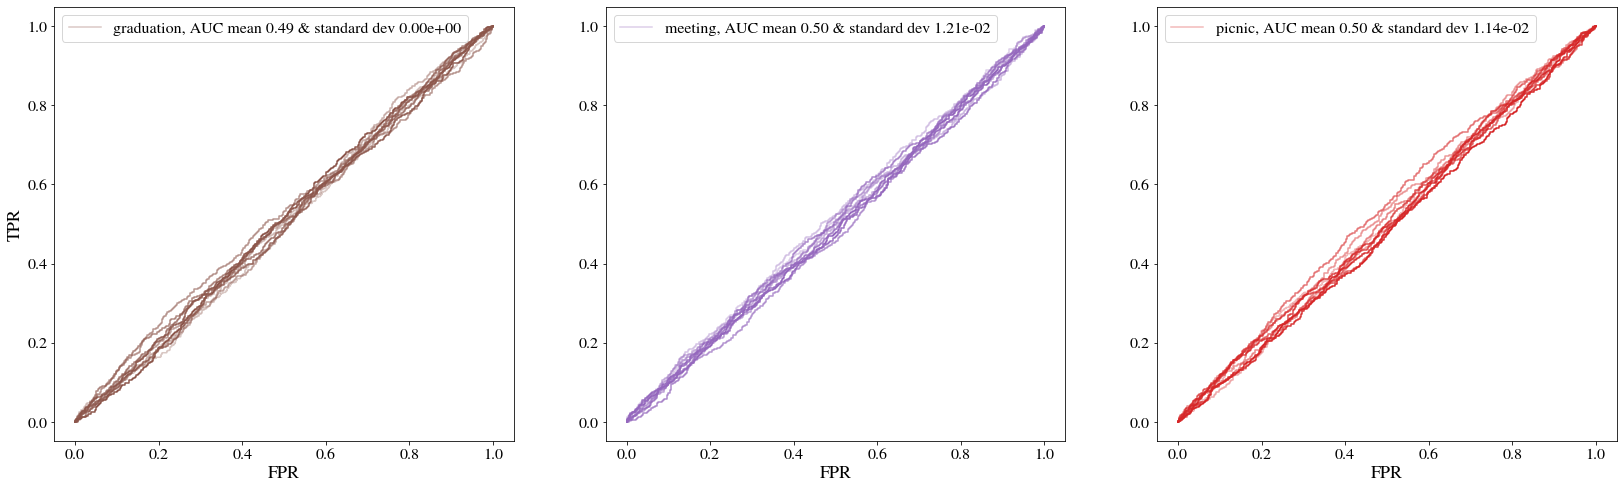

In [34]:
plt.rcParams["figure.figsize"] = (28,8)
fig, axs = plt.subplots(1,3)

class_dict = valid_it.class_indices
color_dict = {'picnic':'C3','meeting':'C4','graduation':'C5'}

for i in range(kfold):
    fpr = kc_dict['fpr_%i'%i]
    tpr = kc_dict['tpr_%i'%i]
    roc_mean = []
    for key, val in class_dict.items():
        roc_mean.append(roc_auc[key])
        alil = 1. - 0.075 * i
        if i == kfold-1:
            axs[val].plot(fpr[key], tpr[key],color=color_dict[key],label=key+', AUC mean %.2f & standard dev %.2e'%(np.mean(roc_mean),np.std(roc_mean)),alpha=alil)
        else:
            axs[val].plot(fpr[key], tpr[key],color=color_dict[key],alpha=alil)

axs[0].set_xlabel(r'FPR', fontsize=18)
axs[1].set_xlabel(r'FPR', fontsize=18)
axs[2].set_xlabel(r'FPR', fontsize=18)
axs[0].set_ylabel(r'TPR', fontsize=18)
axs[0].legend(loc=0)
axs[1].legend(loc=0)
axs[2].legend(loc=0)
plt.savefig('img-cla_KF-roc.pdf')

In [16]:
# K-Fold Cross Validation
kf = KFold(n_splits = kfold)

i = 0

kc_dict = {}

for train_index, val_index in kf.split(labels_df['filename']):
    train_df = labels_df.iloc[train_index]
    val_df = labels_df.iloc[val_index]

    # create a data generator
    datagen = ImageDataGenerator(rescale=1./255.,preprocessing_function=rgb2gray)

    train_it = datagen.flow_from_dataframe(train_df,directory ='data_folder',x_col = "filename", y_col = "category", \
                                        class_mode = "categorical",batch_size=32,target_size=size_im)
    valid_it = datagen.flow_from_dataframe(val_df,directory ='data_folder',x_col = "filename", y_col = "category", \
                                        class_mode = "categorical",batch_size=32,target_size=size_im)
    
    model_kf_deep = Conv2D_model(input_im,3,deeper=True)

    # Compile the model.
    model_kf_deep.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )
    
    # Train the model.
    train_kf_deep = model_kf_deep.fit(
    train_it,
    epochs=epochs,
    batch_size=32,
    validation_data = valid_it
    )

    # save model and architecture to single file
    model_kf_deep.save("img-cla_deep_%i.h5"%i)

    predict_labels = model_kf_deep.predict(valid_it,batch_size=32)
    true_labels = to_categorical(valid_it.labels)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    threeshold = dict()
    roc_auc = dict()
    for key, val in valid_it.class_indices.items():
        fpr[key], tpr[key], threeshold[key] = roc_curve(true_labels[:, val], predict_labels[:, val])
        roc_auc[key] = auc(fpr[key], tpr[key])

        kc_dict['loss_%i'%i] = train_kf_deep.history['loss']
        kc_dict['val_loss_%i'%i] = train_kf_deep.history['val_loss']
        kc_dict['accuracy_%i'%i] = train_kf_deep.history['accuracy']
        kc_dict['val_accuracy_%i'%i] = train_kf_deep.history['val_accuracy']
        kc_dict['fpr_%i'%i] = fpr
        kc_dict['tpr_%i'%i] = tpr
        kc_dict['roc_auc_%i'%i] = roc_auc
        kc_dict['class_dict_%i'%i] = valid_it.class_indices

    i += 1

Found 18888 validated image filenames belonging to 3 classes.
Found 2099 validated image filenames belonging to 3 classes.
Epoch 1/10
591/591 [==============================] - 173s 290ms/step - loss: 1.0409 - accuracy: 0.5139 - val_loss: 1.0126 - val_accuracy: 0.4993
Epoch 2/10
591/591 [==============================] - 171s 289ms/step - loss: 0.8648 - accuracy: 0.6134 - val_loss: 0.8684 - val_accuracy: 0.6127
Epoch 3/10
591/591 [==============================] - 172s 291ms/step - loss: 0.8240 - accuracy: 0.6360 - val_loss: 0.9636 - val_accuracy: 0.5769
Epoch 4/10
591/591 [==============================] - 171s 289ms/step - loss: 0.8089 - accuracy: 0.6457 - val_loss: 0.8697 - val_accuracy: 0.6184
Epoch 5/10
591/591 [==============================] - 171s 290ms/step - loss: 0.7888 - accuracy: 0.6561 - val_loss: 0.8780 - val_accuracy: 0.6122
Epoch 6/10
591/591 [==============================] - 171s 289ms/step - loss: 0.7639 - accuracy: 0.6671 - val_loss: 0.8337 - val_accuracy: 0.6236
E

591/591 [==============================] - 170s 288ms/step - loss: 0.8936 - accuracy: 0.5946 - val_loss: 0.9402 - val_accuracy: 0.5646
Epoch 3/10
591/591 [==============================] - 171s 289ms/step - loss: 0.8589 - accuracy: 0.6139 - val_loss: 0.8872 - val_accuracy: 0.5941
Epoch 4/10
591/591 [==============================] - 170s 288ms/step - loss: 0.8066 - accuracy: 0.6476 - val_loss: 0.9513 - val_accuracy: 0.5741
Epoch 5/10
591/591 [==============================] - 170s 288ms/step - loss: 0.7968 - accuracy: 0.6485 - val_loss: 0.9782 - val_accuracy: 0.5741
Epoch 6/10
591/591 [==============================] - 170s 288ms/step - loss: 0.7810 - accuracy: 0.6615 - val_loss: 0.9555 - val_accuracy: 0.5917
Epoch 7/10
591/591 [==============================] - 170s 288ms/step - loss: 0.7375 - accuracy: 0.6854 - val_loss: 1.0592 - val_accuracy: 0.5541
Epoch 8/10
591/591 [==============================] - 172s 291ms/step - loss: 0.7203 - accuracy: 0.6975 - val_loss: 0.9356 - val_accura

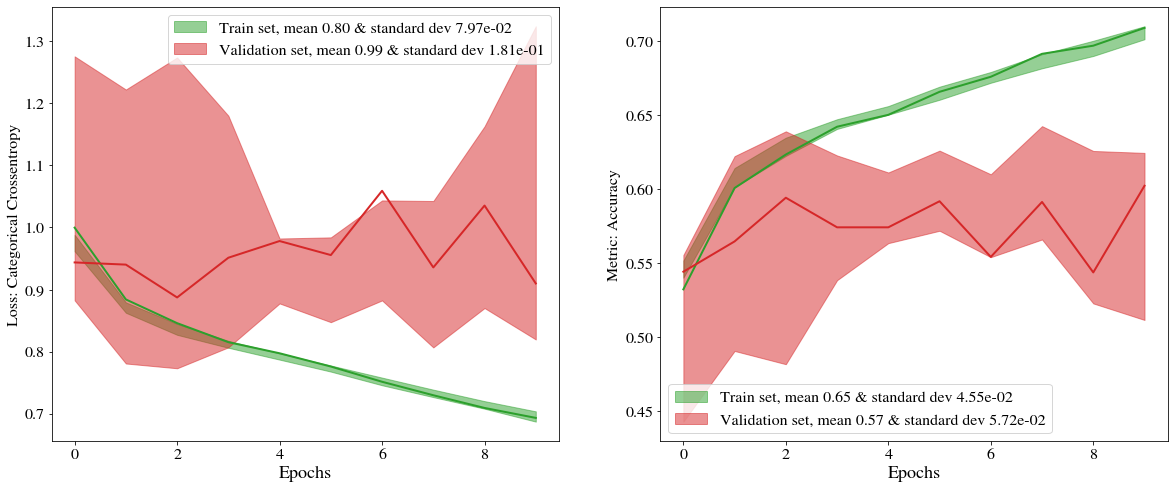

In [159]:
plt.rcParams["figure.figsize"] = (20,8)
fig, axs = plt.subplots(1,2)

# Global and by epoch statitics
loss_epoch_mean, loss_epoch_std = stats_epochs(kc_dict,'loss',epochs)
val_loss_epoch_mean, val_loss_epoch_std = stats_epochs(kc_dict,'val_loss',epochs)
acc_epoch_mean, acc_epoch_std = stats_epochs(kc_dict,'accuracy',epochs)
val_acc_epoch_mean, val_acc_epoch_std = stats_epochs(kc_dict,'val_accuracy',epochs)

loss_mean, loss_std = stats_global(kc_dict,'loss',epochs)
val_loss_mean, val_loss_std = stats_global(kc_dict,'val_loss',epochs)
acc_mean, acc_std = stats_global(kc_dict,'accuracy',epochs)
val_acc_mean, val_acc_std = stats_global(kc_dict,'val_accuracy',epochs)


axs[0].fill_between(np.arange(epochs),loss_epoch_mean - loss_epoch_std, \
                    loss_epoch_mean + loss_epoch_std,color='C2',alpha=0.5, \
                    label='Train set, mean %.2f & standard dev %.2e'%(loss_mean,loss_std))
axs[0].fill_between(np.arange(epochs),val_loss_epoch_mean - val_loss_epoch_std, \
                    val_loss_epoch_mean + val_loss_epoch_std,color='C3',alpha=0.5, \
                    label='Validation set, mean %.2f & standard dev %.2e'%(val_loss_mean,val_loss_std))

axs[1].fill_between(np.arange(epochs),acc_epoch_mean - acc_epoch_std, \
                    acc_epoch_mean + acc_epoch_std,color='C2',alpha=0.5, \
                    label='Train set, mean %.2f & standard dev %.2e'%(acc_mean,acc_std))
axs[1].fill_between(np.arange(epochs),val_acc_epoch_mean - val_acc_epoch_std, \
                    val_acc_epoch_mean + val_acc_epoch_std,color='C3',alpha=0.5, \
                    label='Validation set, mean %.2f & standard dev %.2e'%(val_acc_mean,val_acc_std))

#Iteration with best performance
iperf, auc_iperf = best_performance(kc_dict,epochs)
axs[0].plot(kc_dict['loss_%i'%iperf],lw=2.,color='C2')
axs[0].plot(kc_dict['val_loss_%i'%iperf],lw=2,color='C3')
axs[1].plot(kc_dict['accuracy_%i'%iperf],lw=2,color='C2')
axs[1].plot(kc_dict['val_accuracy_%i'%iperf],lw=2,color='C3')

axs[0].set_xlabel(r'Epochs', fontsize=18)
axs[0].set_ylabel(r'Loss: Categorical Crossentropy', fontsize=16)
axs[0].legend(loc=0)

axs[1].set_xlabel(r'Epochs', fontsize=18)
axs[1].set_ylabel(r'Metric: Accuracy', fontsize=16)
axs[1].legend(loc=0)

plt.savefig('img-cla-deep_KF-loss-acc.pdf')

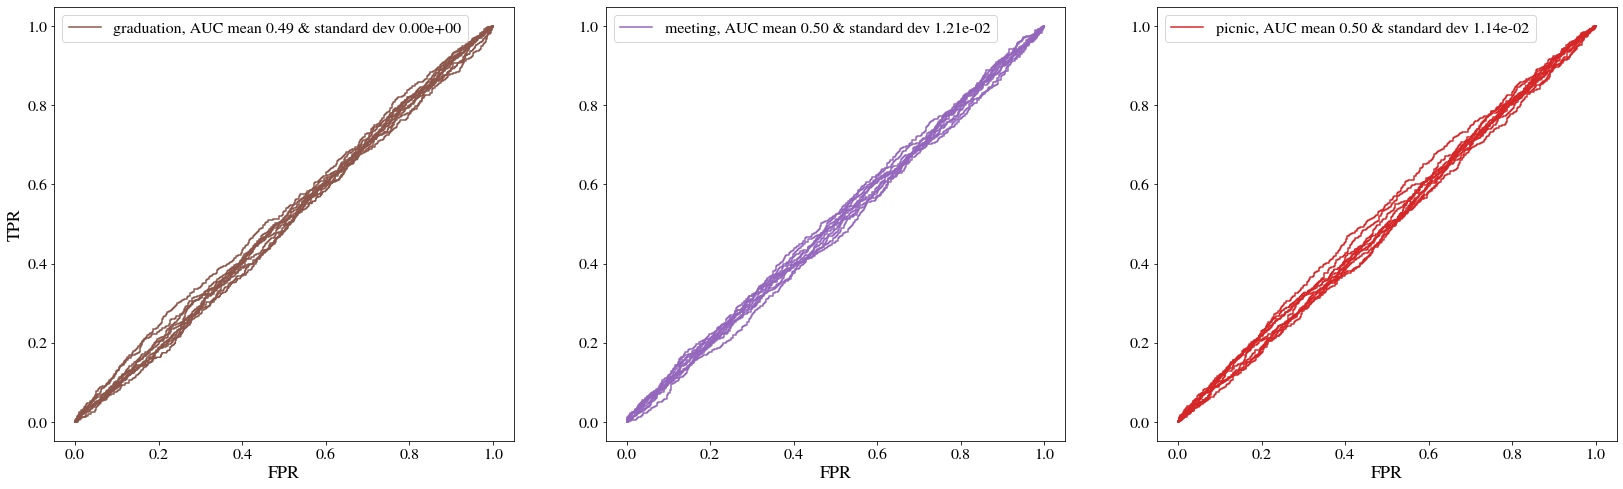

In [36]:
plt.rcParams["figure.figsize"] = (28,8)
fig, axs = plt.subplots(1,3)

class_dict = valid_it.class_indices
color_dict = {'picnic':'C3','meeting':'C4','graduation':'C5'}

for i in range(kfold):
    fpr = kc_dict['fpr_%i'%i]
    tpr = kc_dict['tpr_%i'%i]
    roc_mean = []
    for key, val in class_dict.items():
        roc_mean.append(roc_auc[key])
        alil = 1. - 0.075 * i
        if i == kfold-1:
            axs[val].plot(fpr[key], tpr[key],color=color_dict[key],label=key+', AUC mean %.2f & standard dev %.2e'%(np.mean(roc_mean),np.std(roc_mean)))
        else:
            axs[val].plot(fpr[key], tpr[key],color=color_dict[key])

axs[0].set_xlabel(r'FPR', fontsize=18)
axs[1].set_xlabel(r'FPR', fontsize=18)
axs[2].set_xlabel(r'FPR', fontsize=18)
axs[0].set_ylabel(r'TPR', fontsize=18)
axs[0].legend(loc=0)
axs[1].legend(loc=0)
axs[2].legend(loc=0)

plt.savefig('img-cla-deep_KF-roc.pdf')